In [1]:
import pandas as pd
import numpy as np
from Load_dataset import load_dataset
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from os import listdir
from numpy import array
from numpy import vstack
from pandas import read_csv
from matplotlib import pyplot

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

314 (314,) (314,) (314,)


Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('MovementAAL/dataset/MovementAAL_RSS_1.csv')
df2 = pd.read_csv('MovementAAL/dataset/MovementAAL_RSS_2.csv')

shape1=df1.shape
shape2=df2.shape

print(shape1,shape2)

(27, 4) (26, 4)


From analyzing the shape of different RSS csv files we identified it is of variable length. Because each sequence has a variable length, we can store the NumPy array for each trace in a list.

In [3]:
#loading the data
sequence, target, group, path = load_dataset('MovementAAL/')
# summarize shape of the loaded data
print(len(sequence), target.shape, group.shape, path.shape)

314 (314,) (314,) (314,)


Ploting sequence variables across anchor points and ploting the paths

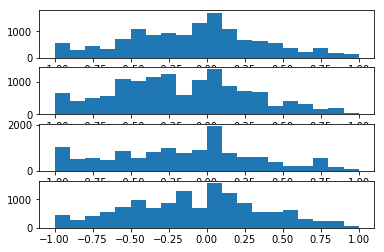

In [4]:
all_rows = vstack(sequence)
pyplot.figure()
variables = [0, 1, 2, 3]
for v in variables:
    pyplot.subplot(len(variables), 1, v+1)
    pyplot.hist(all_rows[:, v], bins=20)
pyplot.show()

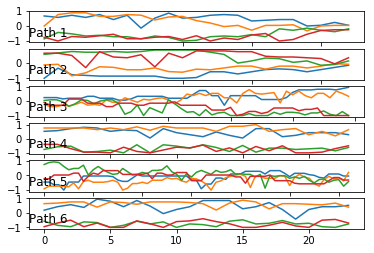

In [5]:
# group sequences by paths
paths = [1,2,3,4,5,6]
seq_paths = dict()
for path in paths:
    seq_paths[path] = [sequence[j] for j in range(len(paths)) if paths[j]==path]
# plot one example of a trace for each path
pyplot.figure()
for i in paths:
    pyplot.subplot(len(paths), 1, i)
    # line plot each variable
    for j in [0, 1, 2, 3]:
        pyplot.plot(seq_paths[i][0][:, j], label='Anchor ' + str(j+1))
    pyplot.title('Path ' + str(i), y=0, loc='left')
pyplot.show()

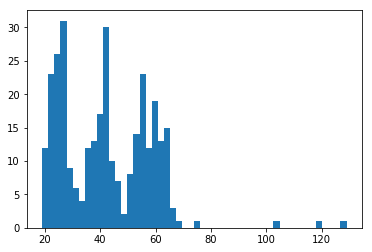

In [6]:
trace_lengths = [len(x) for x in sequence]
pyplot.hist(trace_lengths, bins=50)
pyplot.show()

The grouping of variables over time. Pairs of variables may be grouped together at a given time. Variables bunch together towards the middle or spread apart towards the extremes.

Since im using LSTM(RNN) model for variable length multivariate time-series. Padding the sequence to fixed length

In [7]:
#for finding ideal length
len_sequence = []
for one_seq in sequence:
    len_sequence.append(len(one_seq))
pd.Series(len_sequence).describe()

count    314.000000
mean      42.028662
std       16.185303
min       19.000000
25%       26.000000
50%       41.000000
75%       56.000000
max      129.000000
dtype: float64

In [8]:
#Padding the sequence with the values to max length
to_pad = 129
new_seq = []
for one_seq in sequence:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(4, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)
print(len(final_seq))
#print(sequence)

314


In [9]:
from keras.preprocessing import sequence
seq_len = 70 # as most data is within 60 from looking at the distribution of traces 
final_seq=sequence.pad_sequences(final_seq,maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [10]:
# separate traces
train = [final_seq[i] for i in range(len(group)) if group[i]==1]
validation = [final_seq[i] for i in range(len(group)) if group[i]==2]
test = [final_seq[i] for i in range(len(group)) if group[i]==3]
print(len(train),len(validation),len(test))
# separate target
train_target = [target[i] for i in range(len(group)) if group[i]==1]
validation_target = [target[i] for i in range(len(group)) if group[i]==2]
test_target = [target[i] for i in range(len(group)) if group[i]==3]
print(len(train_target),len(validation_target),len(test_target))

104 106 104
104 106 104


In [11]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target = (train_target+1)/2

validation_target = np.array(validation_target)
validation_target = (validation_target+1)/2

test_target = np.array(test_target)
test_target = (test_target+1)/2

#print(validation,validation_target)

In [12]:
#building and applying LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [13]:
#training and checking accuracy on validation data
adam = Adam(lr=0.001)
chk = ModelCheckpoint('model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data = (validation,validation_target))

Instructions for updating:
Use tf.cast instead.
Train on 104 samples, validate on 106 samples
Epoch 1/200
104/104 [==============================] - 1s 13ms/step - loss: 0.6969 - acc: 0.3942 - val_loss: 0.6939 - val_acc: 0.4906

Epoch 00001: val_acc improved from -inf to 0.49057, saving model to model.pkl
Epoch 2/200
104/104 [==============================] - 0s 5ms/step - loss: 0.6885 - acc: 0.5673 - val_loss: 0.6988 - val_acc: 0.5000

Epoch 00002: val_acc improved from 0.49057 to 0.50000, saving model to model.pkl
Epoch 3/200
104/104 [==============================] - 1s 5ms/step - loss: 0.6859 - acc: 0.5769 - val_loss: 0.7051 - val_acc: 0.4906

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/200
104/104 [==============================] - 1s 5ms/step - loss: 0.6864 - acc: 0.5769 - val_loss: 0.7062 - val_acc: 0.4811

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/200
104/104 [==============================] - 0s 5ms/step - loss: 0.6859 - acc: 0.5769 - val_loss: 0.


Epoch 00042: val_acc did not improve from 0.61321
Epoch 43/200
104/104 [==============================] - 1s 5ms/step - loss: 0.4465 - acc: 0.8077 - val_loss: 1.0014 - val_acc: 0.5000

Epoch 00043: val_acc did not improve from 0.61321
Epoch 44/200
104/104 [==============================] - 0s 5ms/step - loss: 0.4178 - acc: 0.8269 - val_loss: 1.1099 - val_acc: 0.5000

Epoch 00044: val_acc did not improve from 0.61321
Epoch 45/200
104/104 [==============================] - 0s 5ms/step - loss: 0.4088 - acc: 0.7981 - val_loss: 1.1744 - val_acc: 0.5283

Epoch 00045: val_acc did not improve from 0.61321
Epoch 46/200
104/104 [==============================] - 0s 5ms/step - loss: 0.4125 - acc: 0.8173 - val_loss: 1.2952 - val_acc: 0.5472

Epoch 00046: val_acc did not improve from 0.61321
Epoch 47/200
104/104 [==============================] - 0s 5ms/step - loss: 0.7845 - acc: 0.7115 - val_loss: 1.0422 - val_acc: 0.5283

Epoch 00047: val_acc did not improve from 0.61321
Epoch 48/200
104/104 [==

104/104 [==============================] - 1s 5ms/step - loss: 0.2586 - acc: 0.9231 - val_loss: 1.3513 - val_acc: 0.5000

Epoch 00087: val_acc did not improve from 0.61321
Epoch 88/200
104/104 [==============================] - 1s 5ms/step - loss: 0.2411 - acc: 0.9231 - val_loss: 1.4402 - val_acc: 0.4811

Epoch 00088: val_acc did not improve from 0.61321
Epoch 89/200
104/104 [==============================] - 1s 5ms/step - loss: 0.2530 - acc: 0.9038 - val_loss: 1.4543 - val_acc: 0.5377

Epoch 00089: val_acc did not improve from 0.61321
Epoch 90/200
104/104 [==============================] - 1s 6ms/step - loss: 0.2513 - acc: 0.9038 - val_loss: 1.5383 - val_acc: 0.5000

Epoch 00090: val_acc did not improve from 0.61321
Epoch 91/200
104/104 [==============================] - 0s 5ms/step - loss: 0.2586 - acc: 0.9038 - val_loss: 1.4598 - val_acc: 0.5377

Epoch 00091: val_acc did not improve from 0.61321
Epoch 92/200
104/104 [==============================] - 1s 5ms/step - loss: 0.1986 - acc


Epoch 00131: val_acc did not improve from 0.61321
Epoch 132/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0658 - acc: 0.9808 - val_loss: 2.0694 - val_acc: 0.4906

Epoch 00132: val_acc did not improve from 0.61321
Epoch 133/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0581 - acc: 1.0000 - val_loss: 2.0942 - val_acc: 0.4906

Epoch 00133: val_acc did not improve from 0.61321
Epoch 134/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0551 - acc: 1.0000 - val_loss: 2.1753 - val_acc: 0.4717

Epoch 00134: val_acc did not improve from 0.61321
Epoch 135/200
104/104 [==============================] - 0s 4ms/step - loss: 0.0549 - acc: 0.9904 - val_loss: 2.2044 - val_acc: 0.4811

Epoch 00135: val_acc did not improve from 0.61321
Epoch 136/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0497 - acc: 0.9904 - val_loss: 2.2228 - val_acc: 0.5000

Epoch 00136: val_acc did not improve from 0.61321
Epoch 137/200
104/1

104/104 [==============================] - 0s 5ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 2.7737 - val_acc: 0.5283

Epoch 00176: val_acc did not improve from 0.61321
Epoch 177/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 2.7839 - val_acc: 0.5283

Epoch 00177: val_acc did not improve from 0.61321
Epoch 178/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 2.7899 - val_acc: 0.5283

Epoch 00178: val_acc did not improve from 0.61321
Epoch 179/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 2.7941 - val_acc: 0.5283

Epoch 00179: val_acc did not improve from 0.61321
Epoch 180/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 2.7999 - val_acc: 0.5283

Epoch 00180: val_acc did not improve from 0.61321
Epoch 181/200
104/104 [==============================] - 0s 5ms/step - loss: 0.0026 

In [14]:
#checking accuracy of model on the test data
model = load_model('model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.5096153846153846